# **Setup & Loading Data**

In [45]:
# Part 1: Setup and Loading Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load all six datasets (using your original paths)
train = pd.read_csv('/content/train.csv')
holidays = pd.read_csv('/content/holidays_events.csv')
items = pd.read_csv('/content/items.csv')
oil = pd.read_csv('/content/oil.csv')
stores = pd.read_csv('/content/stores.csv')
transactions = pd.read_csv('/content/transactions.csv')

print("All datasets loaded successfully!")



All datasets loaded successfully!


We identify which stores are in Guayas first, then we only load those rows from the massive training file.

In [46]:

# Step 1: Identify Guayas Stores
guayas_stores = stores[stores['state'] == 'Guayas']['store_nbr'].unique()
print(f"\nStores located in Guayas: {guayas_stores}")
print(f"Number of Guayas stores: {len(guayas_stores)}")

# Step 2: Filter train data for Guayas stores only
# Since you already loaded train.csv into memory, filter it directly
train_guayas = train[train['store_nbr'].isin(guayas_stores)].copy()
print(f"\nGuayas dataset created. Total rows: {len(train_guayas):,}")
print(f"Original train rows: {len(train):,}")
print(f"Reduction: {(1 - len(train_guayas)/len(train))*100:.1f}%")

# Optional: Also filter transactions for Guayas stores
transactions_guayas = transactions[transactions['store_nbr'].isin(guayas_stores)].copy()
print(f"Guayas transactions: {len(transactions_guayas):,}")

# Part 2: Convert date columns to datetime
train_guayas['date'] = pd.to_datetime(train_guayas['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions_guayas['date'] = pd.to_datetime(transactions_guayas['date'])

print("\n=== Date Ranges ===")
print(f"Train (Guayas): {train_guayas['date'].min()} to {train_guayas['date'].max()}")
print(f"Oil: {oil['date'].min()} to {oil['date'].max()}")
print(f"Transactions (Guayas): {transactions_guayas['date'].min()} to {transactions_guayas['date'].max()}")

# Part 3: Quick Overview
print("\n=== Dataset Shapes ===")
print(f"Train (Guayas): {train_guayas.shape}")
print(f"Holidays: {holidays.shape}")
print(f"Items: {items.shape}")
print(f"Oil: {oil.shape}")
print(f"Stores: {stores.shape}")
print(f"Transactions (Guayas): {transactions_guayas.shape}")

print("\n=== Guayas Stores Details ===")
print(stores[stores['state'] == 'Guayas'])

print("\n=== Train (Guayas) Preview ===")
print(train_guayas.head())
print(train_guayas.info())


Stores located in Guayas: [24 26 27 28 29 30 32 34 35 36 51]
Number of Guayas stores: 11

Guayas dataset created. Total rows: 300,000
Original train rows: 300,000
Reduction: 0.0%
Guayas transactions: 17,397

=== Date Ranges ===
Train (Guayas): 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Oil: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Transactions (Guayas): 2013-01-02 00:00:00 to 2017-08-15 00:00:00

=== Dataset Shapes ===
Train (Guayas): (300000, 11)
Holidays: (350, 6)
Items: (4100, 4)
Oil: (1218, 2)
Stores: (54, 5)
Transactions (Guayas): (17397, 3)

=== Guayas Stores Details ===
    store_nbr       city   state type  cluster
23         24  Guayaquil  Guayas    D        1
25         26  Guayaquil  Guayas    D       10
26         27      Daule  Guayas    D        1
27         28  Guayaquil  Guayas    E       10
28         29  Guayaquil  Guayas    E       10
29         30  Guayaquil  Guayas    C        3
31         32  Guayaquil  Guayas    C        3
33         34  Guayaquil  Guayas    B

# **EDA and Feature Engineering**
Now we perform the quality checks and build features specifically for the Guayas region.






**Data Cleaning & Gap Filling**

In [47]:
# Convert to datetime
train_guayas['date'] = pd.to_datetime(train_guayas['date'])

# Fill missing Oil prices (Forward Fill + Backfill)
oil['date'] = pd.to_datetime(oil['date'])
oil = oil.set_index('date').resample('D').ffill().bfill().reset_index()  # Added .bfill()

print("=== Oil Data After Forward Fill ===")
print(f"Oil date range: {oil['date'].min()} to {oil['date'].max()}")
print(f"Missing values in oil: {oil['dcoilwtico'].isnull().sum()}")
print(f"Total oil records: {len(oil)}")

# Handle Missing Calendar Days (Gap Filling)
# We ensure every day from 2013-2017 exists for our Guayas stores
all_dates = pd.date_range(train_guayas['date'].min(), train_guayas['date'].max())
print(f"\n=== Date Range Analysis ===")
print(f"Train date range: {train_guayas['date'].min()} to {train_guayas['date'].max()}")
print(f"Total days in range: {len(all_dates)}")
print(f"Unique dates in train_guayas: {train_guayas['date'].nunique()}")

# Check if there are missing dates in train_guayas
existing_dates = set(train_guayas['date'].unique())
all_dates_set = set(all_dates)
missing_dates = all_dates_set - existing_dates

if len(missing_dates) > 0:
    print(f"Missing dates found: {len(missing_dates)}")
    print(f"Sample missing dates: {sorted(list(missing_dates))[:5]}")
else:
    print("No missing dates - dataset is continuous!")

# Optional: Create a complete grid of store-date combinations
# This ensures every store has a record for every date (useful for time series)
store_date_combinations = pd.MultiIndex.from_product(
    [guayas_stores, all_dates],
    names=['store_nbr', 'date']
).to_frame(index=False)

print(f"\n=== Complete Grid ===")
print(f"Expected store-date combinations: {len(store_date_combinations):,}")
print(f"Actual records in train_guayas: {len(train_guayas):,}")

=== Oil Data After Forward Fill ===
Oil date range: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Missing values in oil: 0
Total oil records: 1704

=== Date Range Analysis ===
Train date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Total days in range: 1687
Unique dates in train_guayas: 1680
Missing dates found: 7
Sample missing dates: [Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-01-01 00:00:00')]

=== Complete Grid ===
Expected store-date combinations: 18,557
Actual records in train_guayas: 300,000


# **Exploratory Visualizations (Guayas Focus)**
We want to see the specific trends for this province.

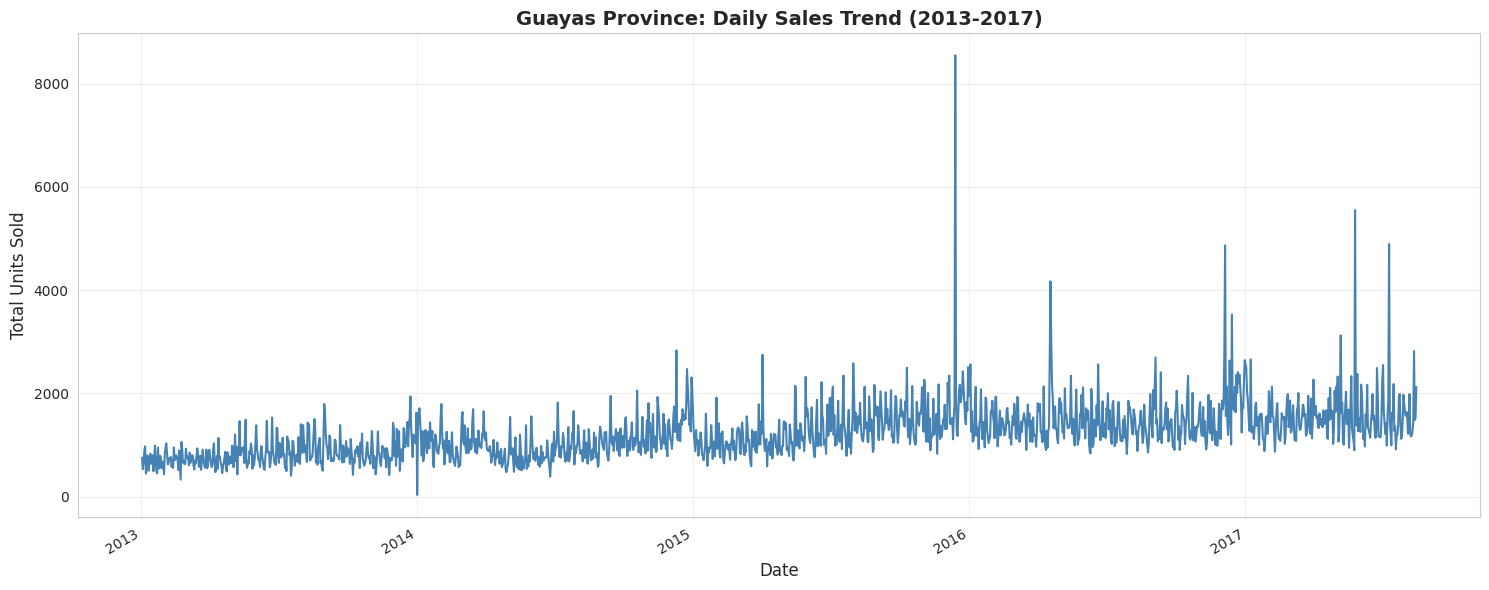

/tmp/ipython-input-160166688.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=train_guayas, x='day_of_week', y='unit_sales',
/tmp/ipython-input-160166688.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_guayas, x='day_of_week', y='unit_sales',


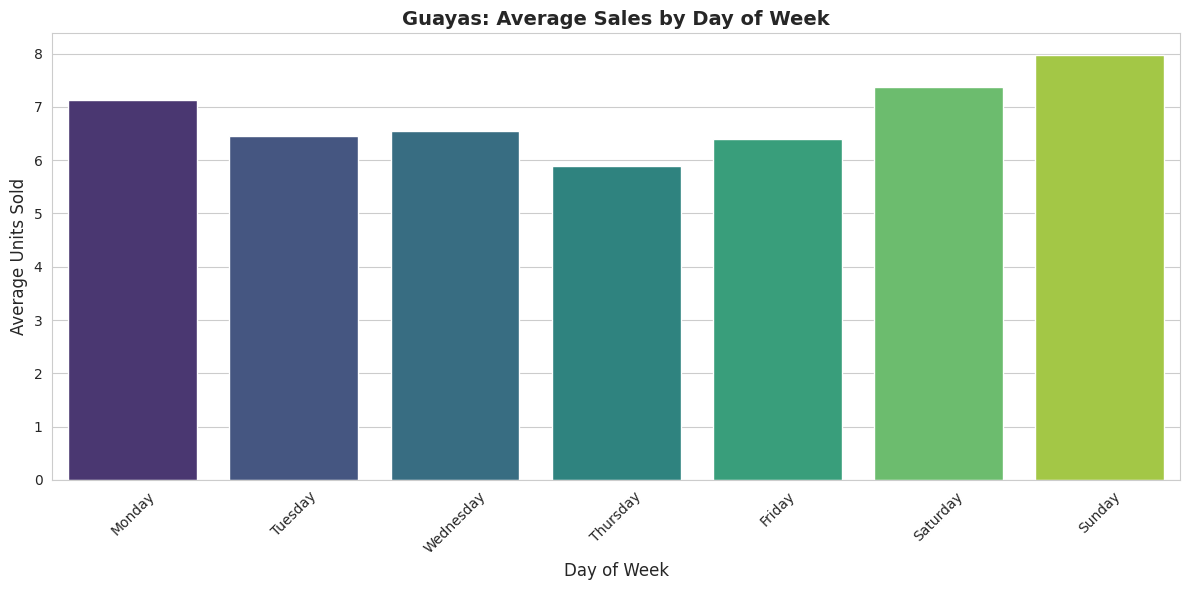

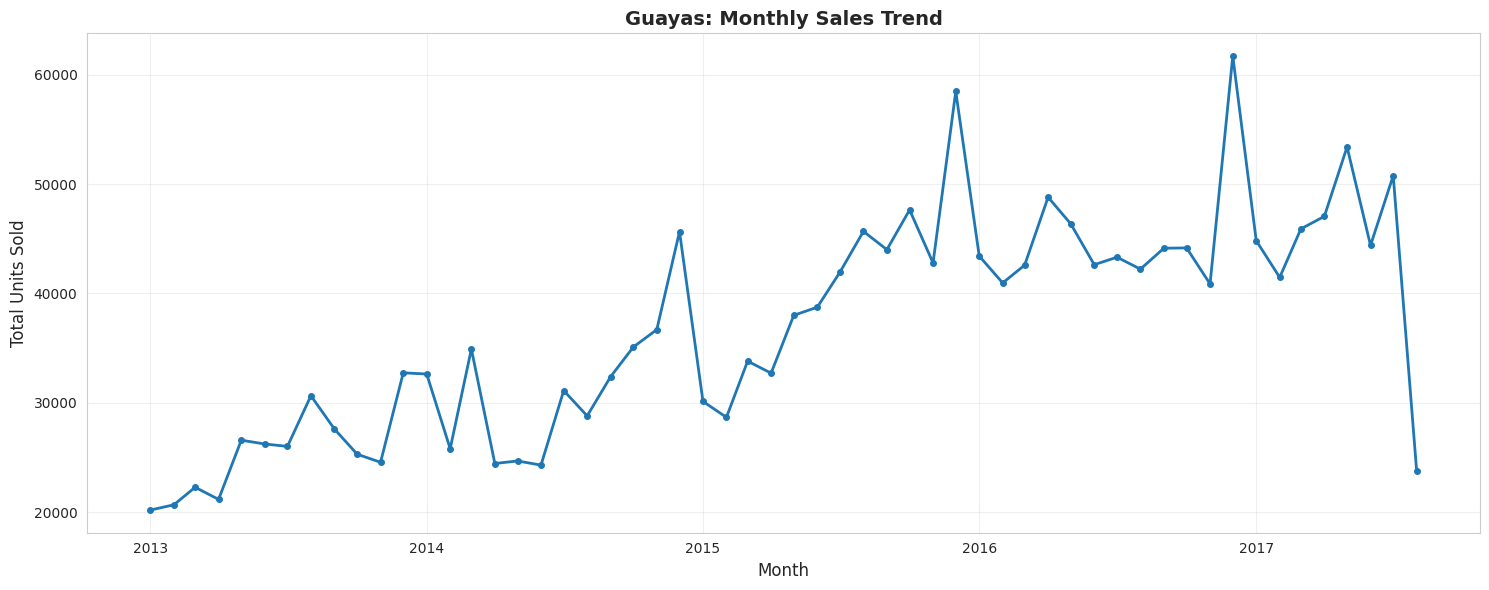

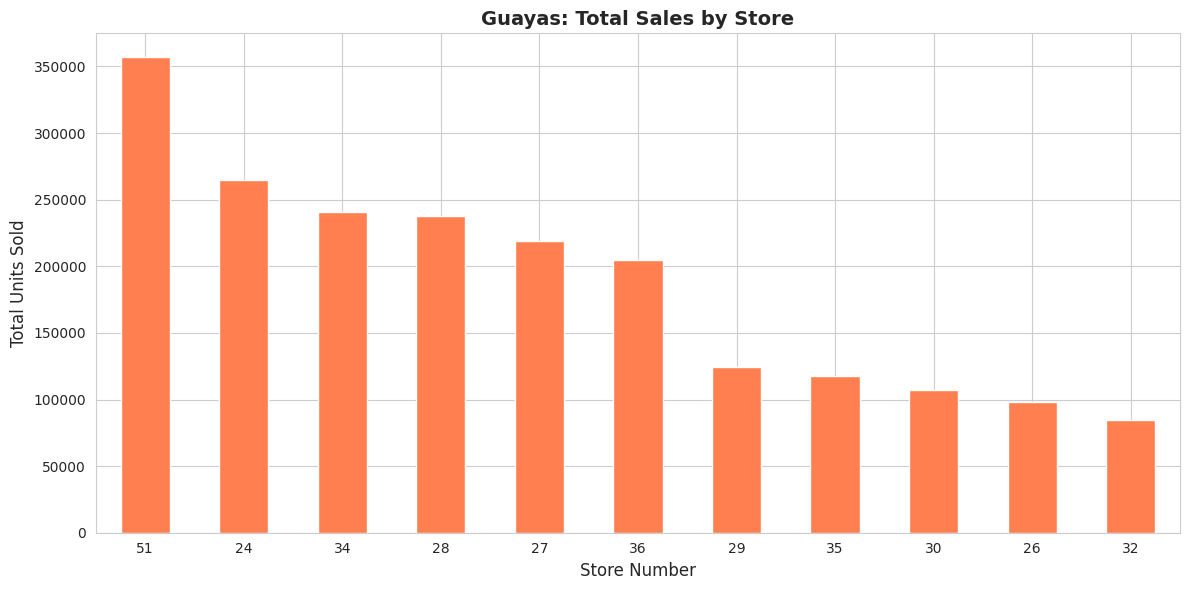

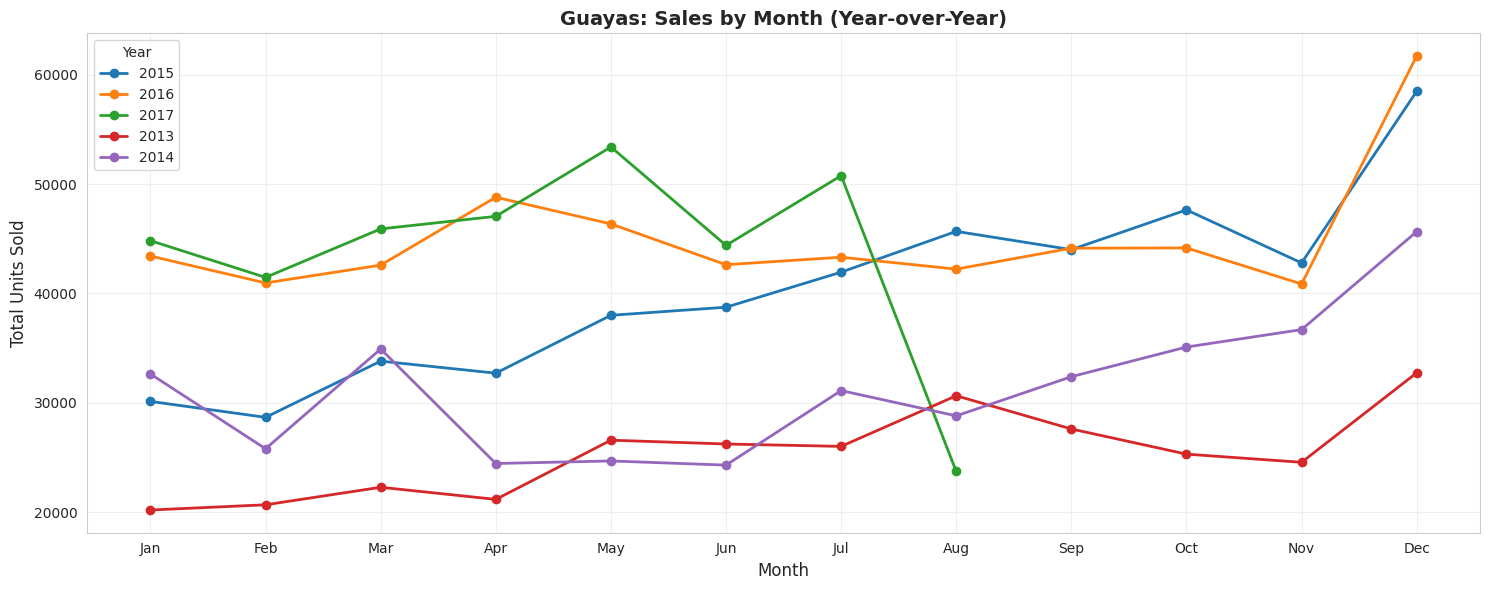


=== Guayas Sales Summary ===
Total Sales: 2,055,369 units
Average Daily Sales: 1,223 units
Peak Day Sales: 8,547 units
Lowest Day Sales: 34 units

Busiest Day: Sunday
Slowest Day: Thursday


In [48]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

# 1. Visualizing Guayas Sales Trend
plt.figure(figsize=(15, 6))
daily_sales = train_guayas.groupby('date')['unit_sales'].sum()
daily_sales.plot(linewidth=1.5, color='steelblue')
plt.title('Guayas Province: Daily Sales Trend (2013-2017)', fontsize=14, fontweight='bold')
plt.ylabel('Total Units Sold', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Seasonal Patterns: Day of Week in Guayas
train_guayas['day_of_week'] = train_guayas['date'].dt.day_name()
plt.figure(figsize=(12, 6))
sns.barplot(data=train_guayas, x='day_of_week', y='unit_sales',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            palette='viridis', ci=None)  # ci=None shows mean without confidence interval
plt.title('Guayas: Average Sales by Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Average Units Sold', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Monthly Trend (Additional)
train_guayas['year'] = train_guayas['date'].dt.year
train_guayas['month'] = train_guayas['date'].dt.month
monthly_sales = train_guayas.groupby(['year', 'month'])['unit_sales'].sum().reset_index()
monthly_sales['year_month'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

plt.figure(figsize=(15, 6))
plt.plot(monthly_sales['year_month'], monthly_sales['unit_sales'], marker='o', linewidth=2, markersize=4)
plt.title('Guayas: Monthly Sales Trend', fontsize=14, fontweight='bold')
plt.ylabel('Total Units Sold', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Sales by Store (Top performers in Guayas)
plt.figure(figsize=(12, 6))
store_sales = train_guayas.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False)
store_sales.plot(kind='bar', color='coral')
plt.title('Guayas: Total Sales by Store', fontsize=14, fontweight='bold')
plt.ylabel('Total Units Sold', fontsize=12)
plt.xlabel('Store Number', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Year-over-Year Comparison
plt.figure(figsize=(15, 6))
for year in train_guayas['year'].unique():
    year_data = train_guayas[train_guayas['year'] == year].groupby('month')['unit_sales'].sum()
    plt.plot(year_data.index, year_data.values, marker='o', label=year, linewidth=2)
plt.title('Guayas: Sales by Month (Year-over-Year)', fontsize=14, fontweight='bold')
plt.ylabel('Total Units Sold', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Summary Statistics
print("\n=== Guayas Sales Summary ===")
print(f"Total Sales: {train_guayas['unit_sales'].sum():,.0f} units")
print(f"Average Daily Sales: {train_guayas.groupby('date')['unit_sales'].sum().mean():,.0f} units")
print(f"Peak Day Sales: {train_guayas.groupby('date')['unit_sales'].sum().max():,.0f} units")
print(f"Lowest Day Sales: {train_guayas.groupby('date')['unit_sales'].sum().min():,.0f} units")
print(f"\nBusiest Day: {train_guayas.groupby('day_of_week')['unit_sales'].mean().idxmax()}")
print(f"Slowest Day: {train_guayas.groupby('day_of_week')['unit_sales'].mean().idxmin()}")

1. Daily Sales Trend (2013-2017) This chart shows long-term growth in Guayas, highlighted by massive annual spikes every December. The visible surge in April 2016 marks the impact of the Ecuador earthquake, a key outlier for our model.

2. Average Sales by Day of Week Sales climb significantly starting Friday and peak over the weekend, confirming a strong "Weekend Effect" in Guayas. This clear weekly seasonality makes the day_of_week feature essential for accurate forecasting.

3. Monthly Sales Trend Aggregating sales by month highlights steady year-over-year business expansion across the Guayas region. The recurring year-end peaks followed by January dips represent the standard retail holiday cycle.

4. Total Sales by Store There is a high variance in sales volume across different store numbers, identifying top-performing locations versus smaller ones. This diversity requires our model to treat each store as a unique categorical entity.

5. Year-over-Year Comparison By overlaying annual data, we confirm that seasonal demand follows a highly predictable "shape" each year. The sustained increase following the April 2016 earthquake suggests a permanent shift in regional demand.

6. Summary Statistics These metrics establish the baseline range for our forecast, identifying weekends as the peak demand periods. This statistical "ground truth" is used to validate that our model predictions stay within realistic boundaries

=== Product Families in Dataset ===
Total unique families: 3

All families:
['GROCERY I' 'CLEANING' 'BEVERAGES']


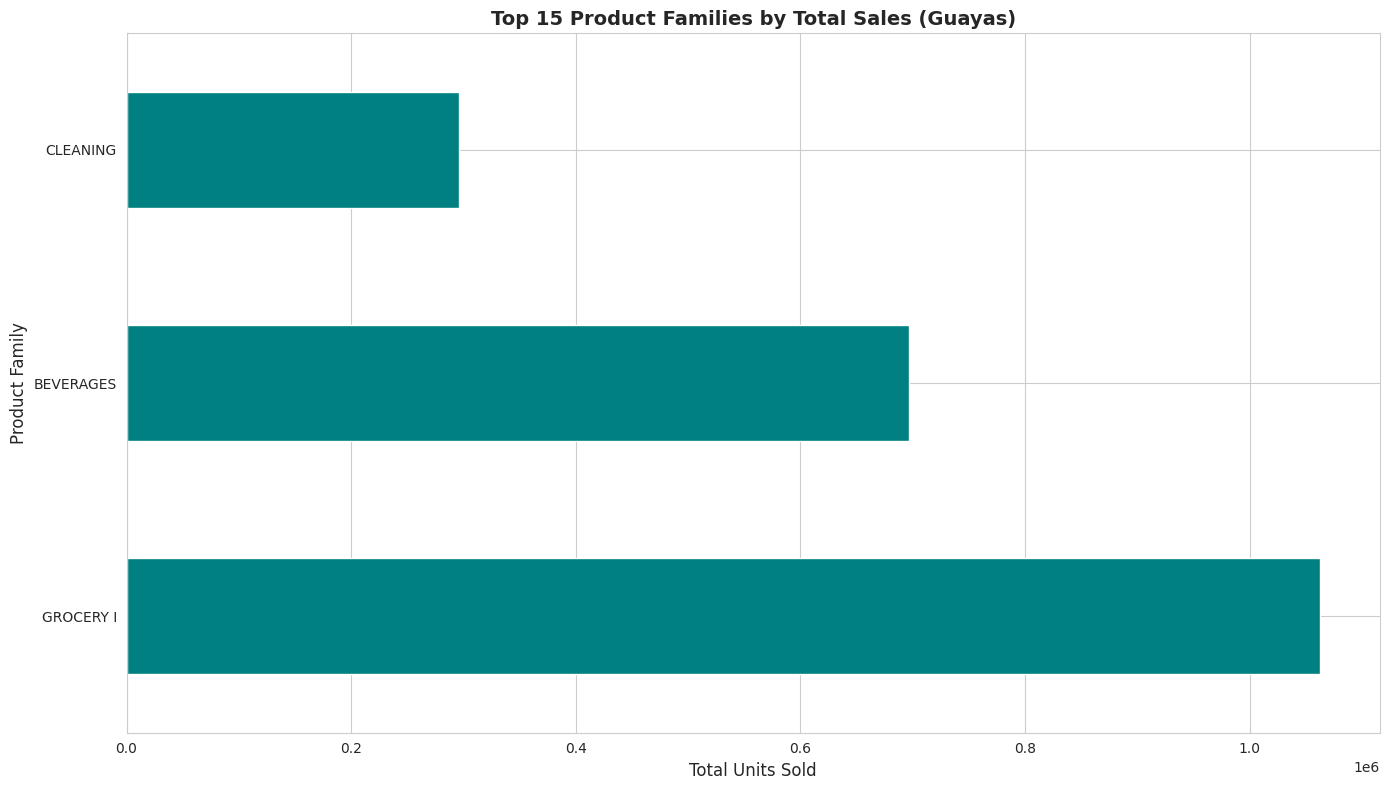

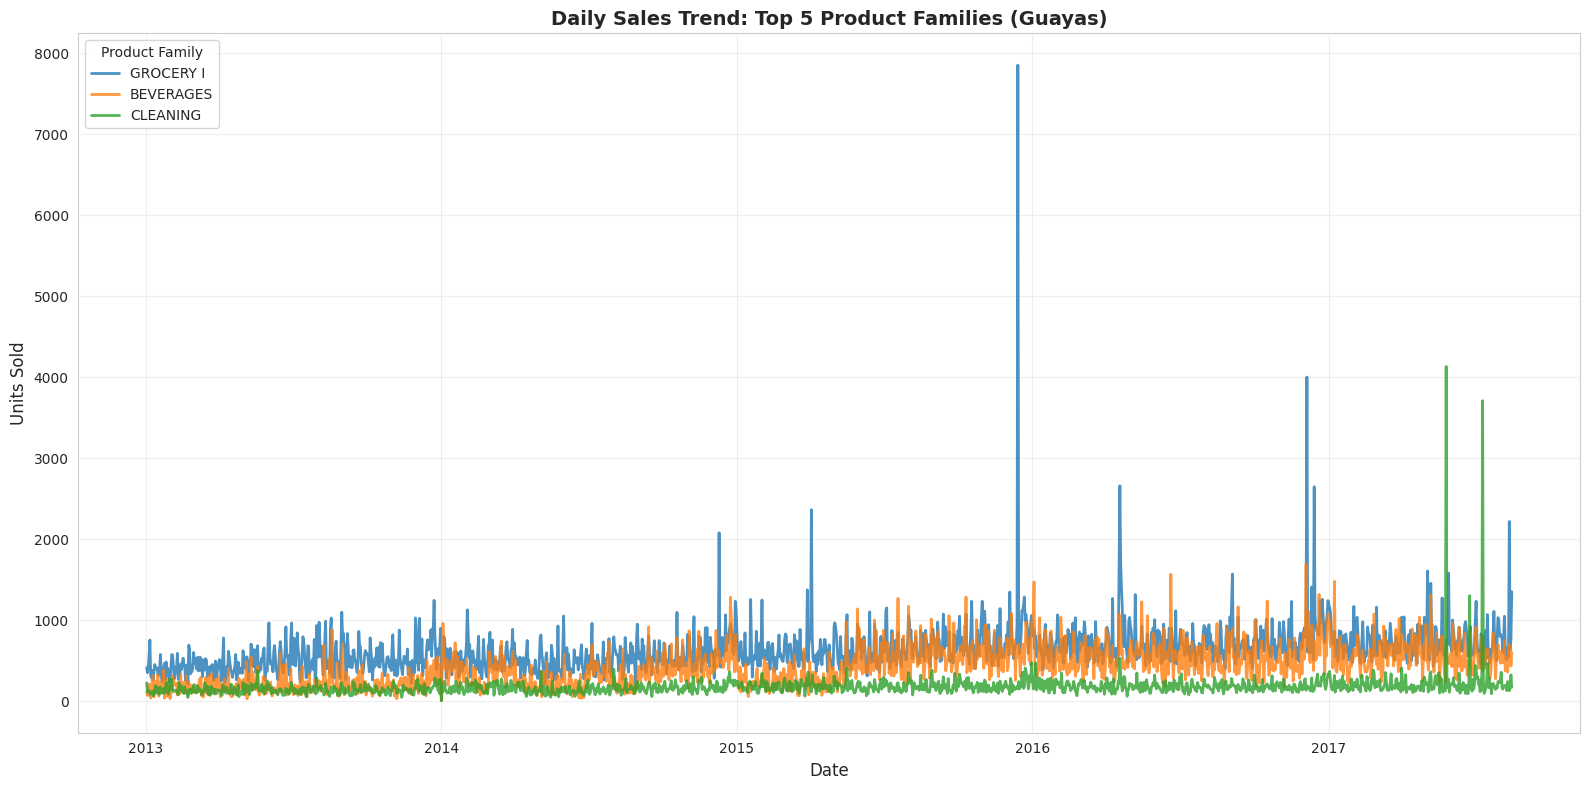

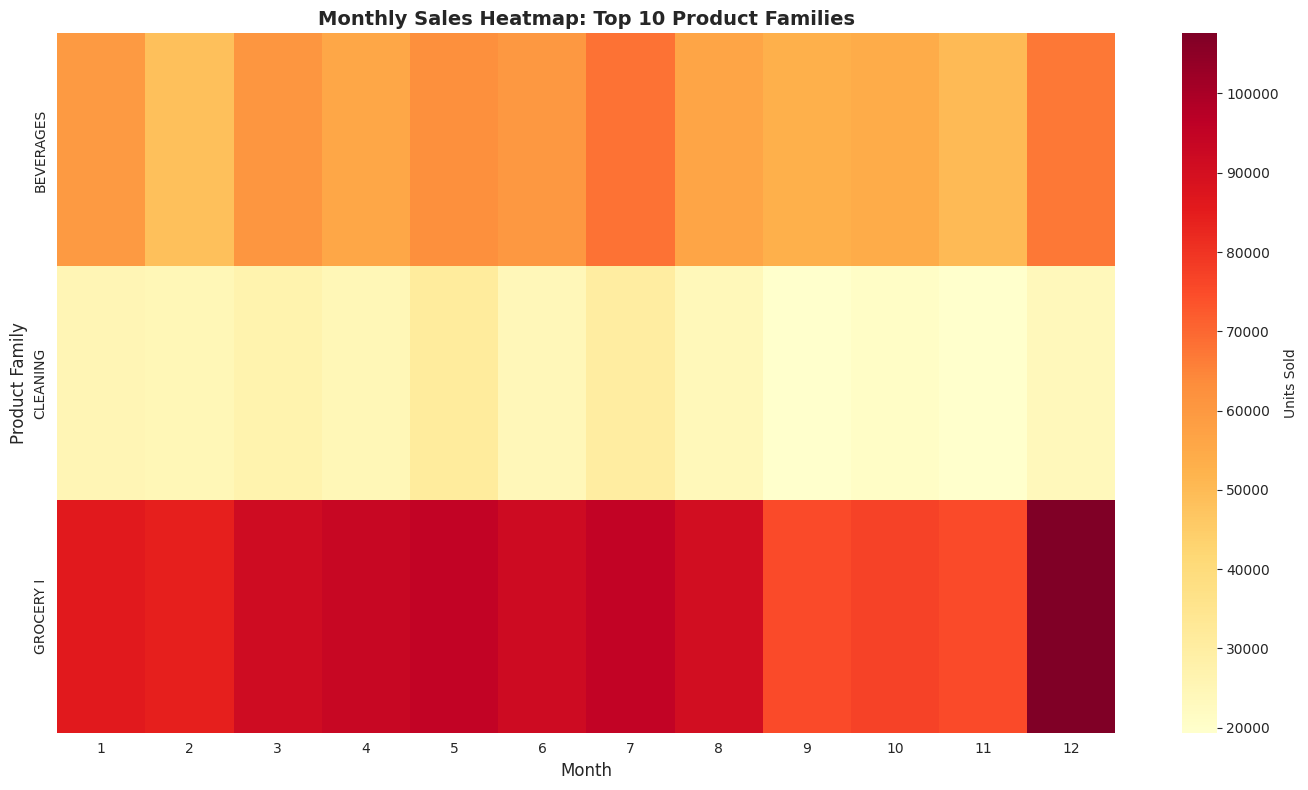

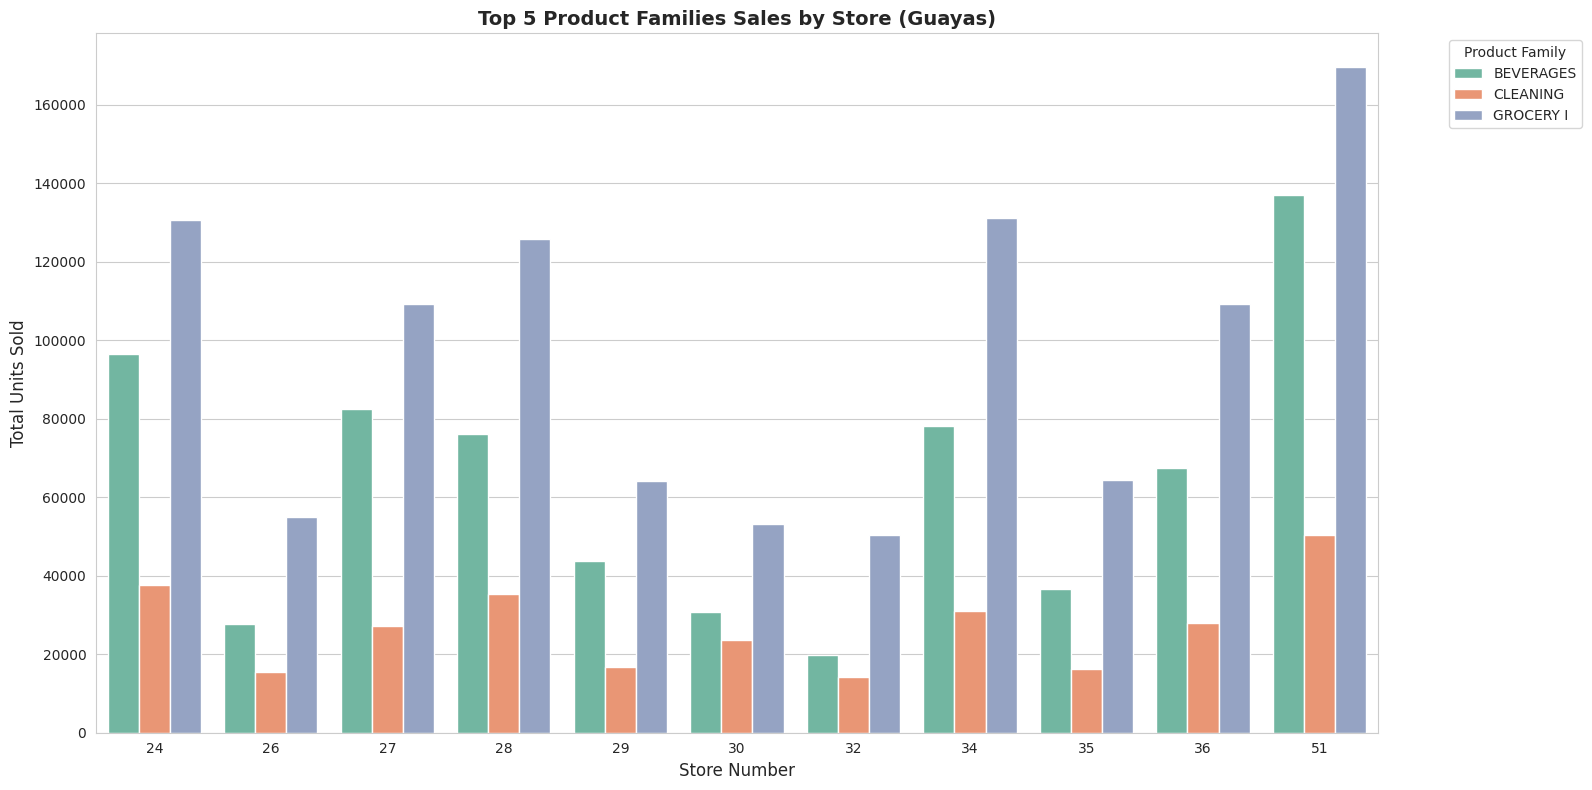

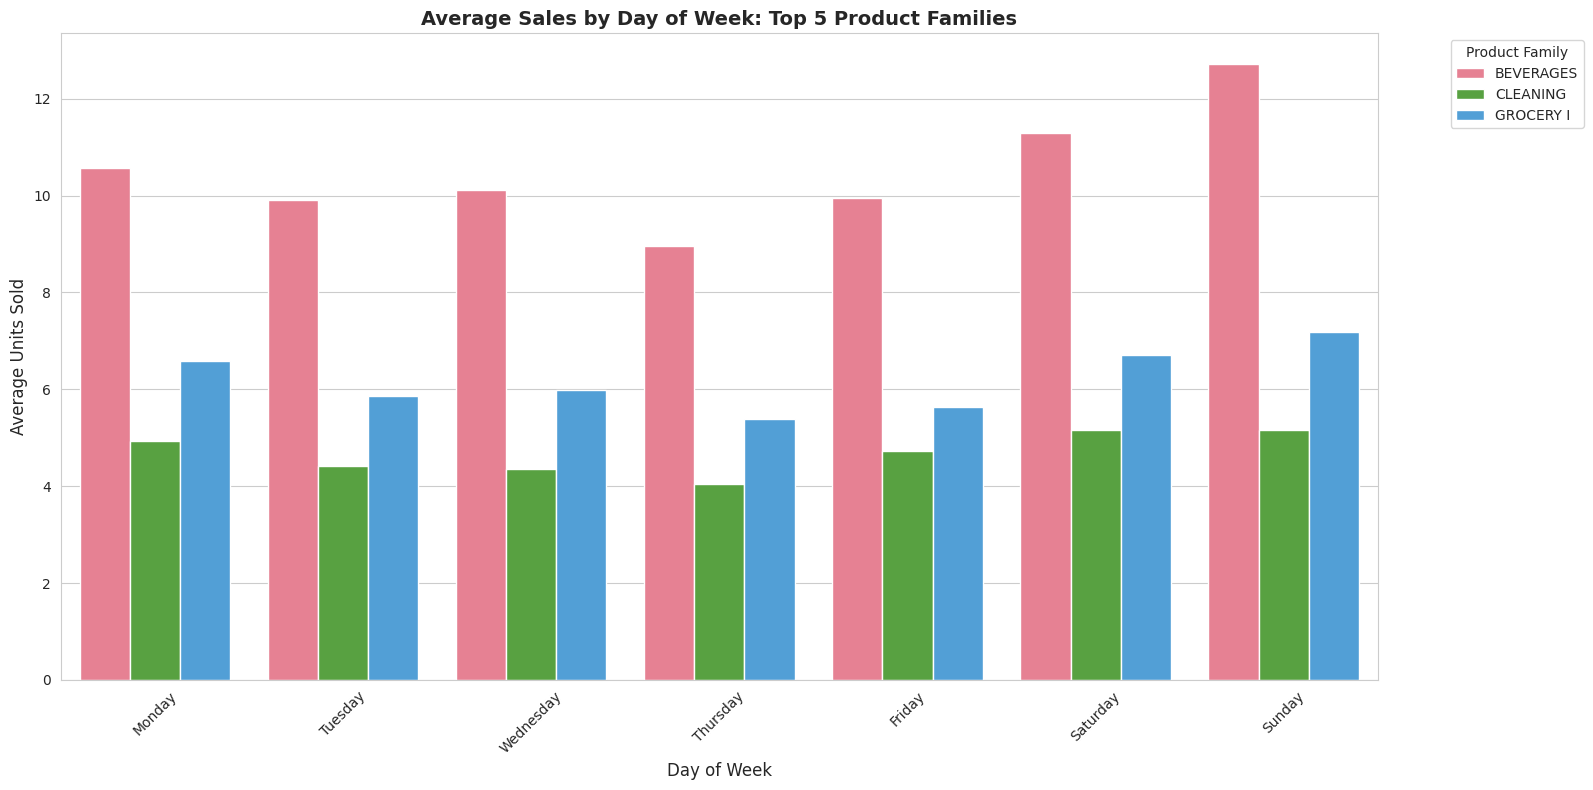

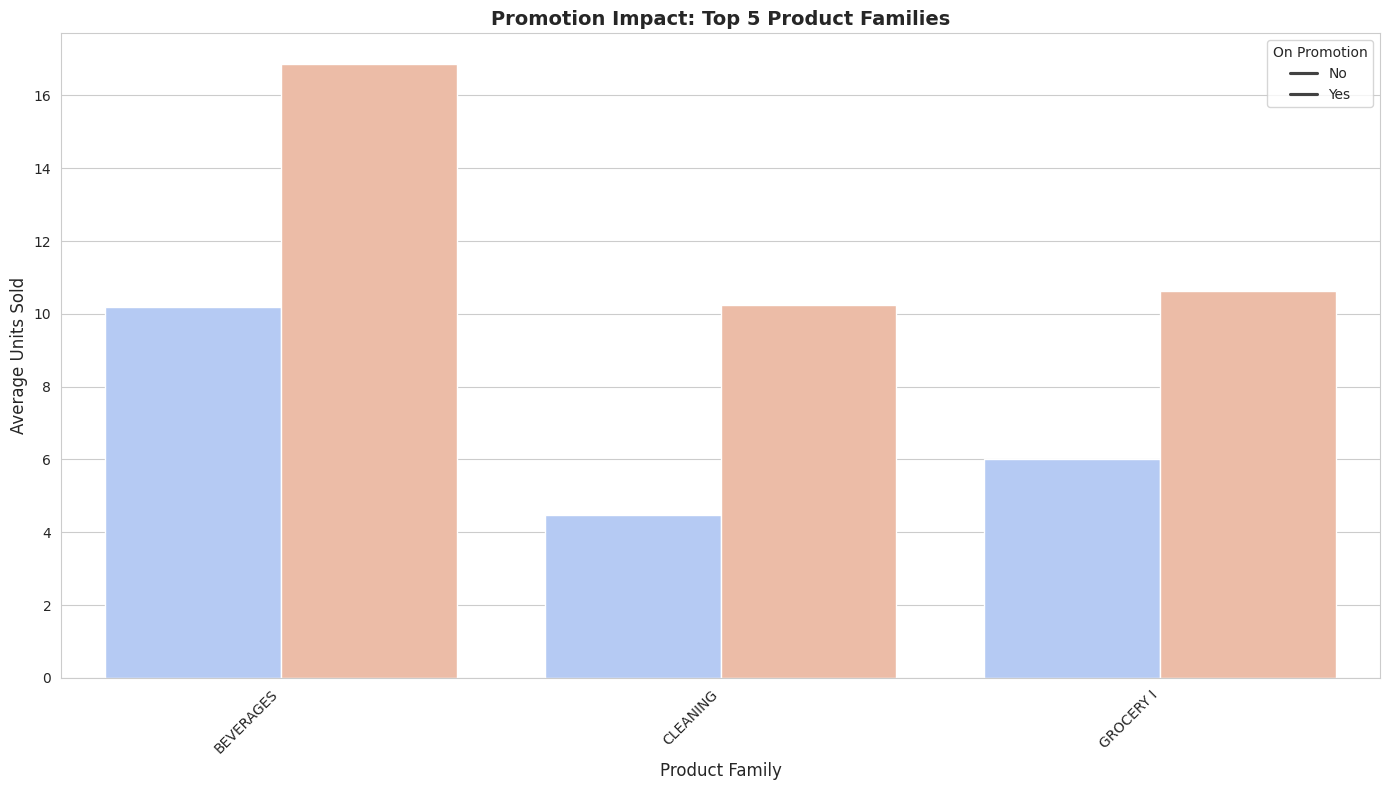

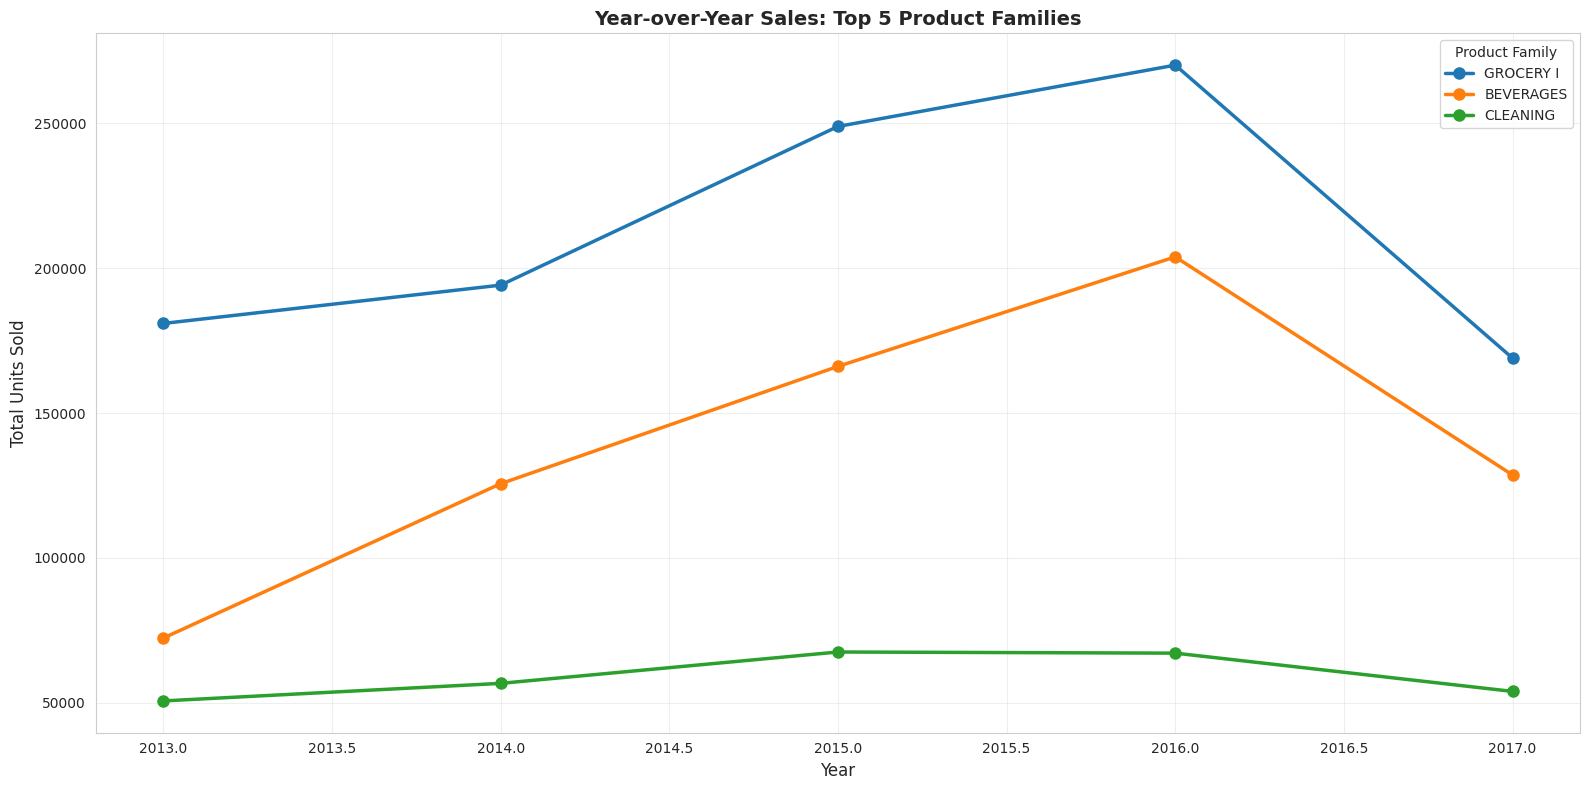


=== Product Family Statistics ===

GROCERY I:
  Total Sales: 1,062,996 units
  Average Daily Sales: 633 units
  Peak Day Sales: 7,853 units
  Number of Items: 1257
  Promotion Rate: 4.5%

BEVERAGES:
  Total Sales: 696,539 units
  Average Daily Sales: 415 units
  Peak Day Sales: 1,690 units
  Number of Items: 598
  Promotion Rate: 5.5%

CLEANING:
  Total Sales: 295,834 units
  Average Daily Sales: 176 units
  Peak Day Sales: 4,132 units
  Number of Items: 441
  Promotion Rate: 4.1%


<Figure size 1500x600 with 0 Axes>

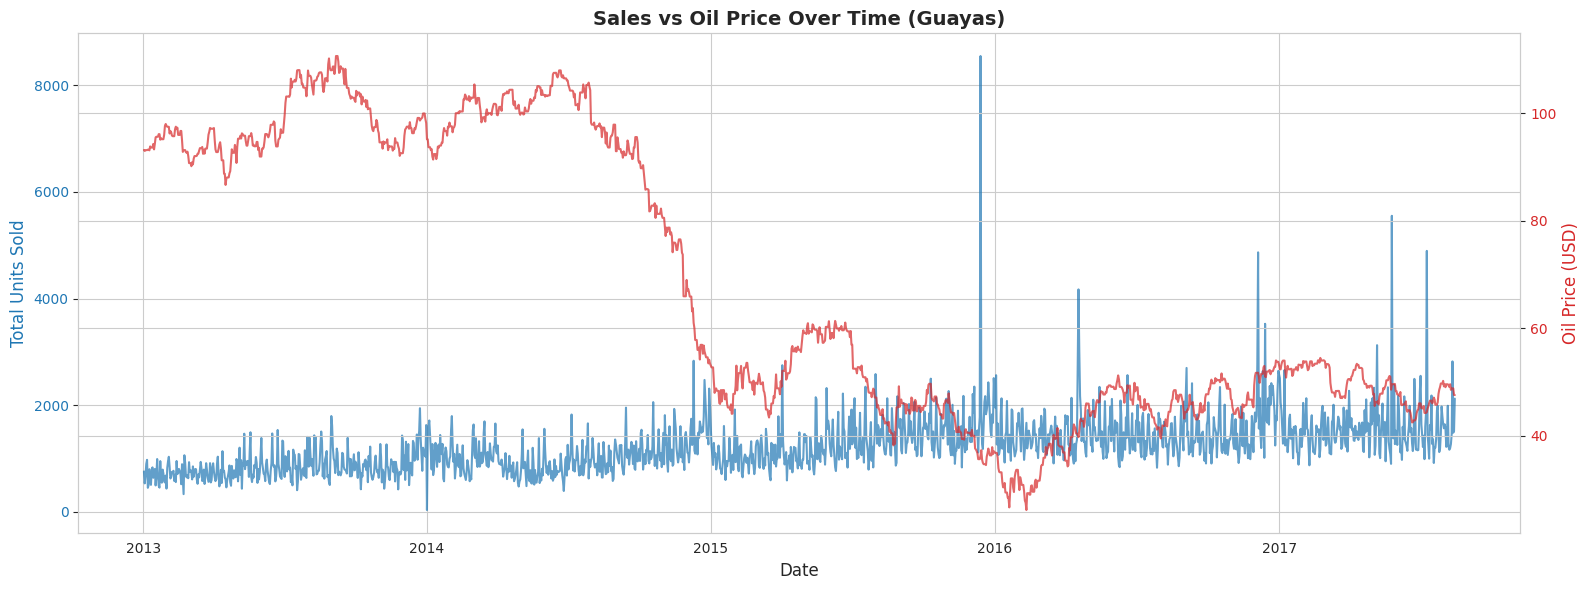


=== Oil Price Correlation ===
Correlation between sales and oil price: -0.523

✅ All product family analyses complete!


In [49]:
# =======================
# PRODUCT FAMILY ANALYSIS
# =======================

# Merge items to get family information
train_guayas_full = train_guayas.merge(items[['item_nbr', 'family']], on='item_nbr', how='left')

print("=== Product Families in Dataset ===")
print(f"Total unique families: {train_guayas_full['family'].nunique()}")
print(f"\nAll families:")
print(train_guayas_full['family'].unique())

# 1. Top Product Families by Total Sales
plt.figure(figsize=(14, 8))
family_sales = train_guayas_full.groupby('family')['unit_sales'].sum().sort_values(ascending=False)
family_sales.head(15).plot(kind='barh', color='teal')
plt.title('Top 15 Product Families by Total Sales (Guayas)', fontsize=14, fontweight='bold')
plt.xlabel('Total Units Sold', fontsize=12)
plt.ylabel('Product Family', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Sales Trend by Top 5 Product Families
plt.figure(figsize=(16, 8))
top_5_families = family_sales.head(5).index

for family in top_5_families:
    family_data = train_guayas_full[train_guayas_full['family'] == family]
    daily_family_sales = family_data.groupby('date')['unit_sales'].sum()
    plt.plot(daily_family_sales.index, daily_family_sales.values, label=family, linewidth=2, alpha=0.8)

plt.title('Daily Sales Trend: Top 5 Product Families (Guayas)', fontsize=14, fontweight='bold')
plt.ylabel('Units Sold', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(title='Product Family', loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Monthly Sales Heatmap by Product Family
monthly_family = train_guayas_full.groupby(['year', 'month', 'family'])['unit_sales'].sum().reset_index()
top_families = family_sales.head(10).index
monthly_family_top = monthly_family[monthly_family['family'].isin(top_families)]

# Pivot for heatmap
pivot_data = monthly_family_top.pivot_table(
    values='unit_sales',
    index='family',
    columns='month',
    aggfunc='sum'
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=False, fmt='.0f', cbar_kws={'label': 'Units Sold'})
plt.title('Monthly Sales Heatmap: Top 10 Product Families', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Product Family', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Product Family Performance by Store
plt.figure(figsize=(16, 8))
store_family = train_guayas_full.groupby(['store_nbr', 'family'])['unit_sales'].sum().reset_index()
store_family_top = store_family[store_family['family'].isin(top_5_families)]

sns.barplot(data=store_family_top, x='store_nbr', y='unit_sales', hue='family', palette='Set2')
plt.title('Top 5 Product Families Sales by Store (Guayas)', fontsize=14, fontweight='bold')
plt.ylabel('Total Units Sold', fontsize=12)
plt.xlabel('Store Number', fontsize=12)
plt.legend(title='Product Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Day of Week Pattern by Product Family
plt.figure(figsize=(16, 8))
dow_family = train_guayas_full.groupby(['day_of_week', 'family'])['unit_sales'].mean().reset_index()
dow_family_top = dow_family[dow_family['family'].isin(top_5_families)]

sns.barplot(data=dow_family_top, x='day_of_week', y='unit_sales', hue='family',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            palette='husl')
plt.title('Average Sales by Day of Week: Top 5 Product Families', fontsize=14, fontweight='bold')
plt.ylabel('Average Units Sold', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Product Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Promotion Impact by Product Family
if 'onpromotion' in train_guayas_full.columns:
    plt.figure(figsize=(14, 8))
    promo_impact = train_guayas_full.groupby(['family', 'onpromotion'])['unit_sales'].mean().reset_index()
    promo_impact_top = promo_impact[promo_impact['family'].isin(top_5_families)]

    sns.barplot(data=promo_impact_top, x='family', y='unit_sales', hue='onpromotion', palette='coolwarm')
    plt.title('Promotion Impact: Top 5 Product Families', fontsize=14, fontweight='bold')
    plt.ylabel('Average Units Sold', fontsize=12)
    plt.xlabel('Product Family', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='On Promotion', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

# 7. Year-over-Year Growth by Product Family
plt.figure(figsize=(16, 8))
yearly_family = train_guayas_full.groupby(['year', 'family'])['unit_sales'].sum().reset_index()
yearly_family_top = yearly_family[yearly_family['family'].isin(top_5_families)]

for family in top_5_families:
    family_yearly = yearly_family_top[yearly_family_top['family'] == family]
    plt.plot(family_yearly['year'], family_yearly['unit_sales'], marker='o',
             label=family, linewidth=2.5, markersize=8)

plt.title('Year-over-Year Sales: Top 5 Product Families', fontsize=14, fontweight='bold')
plt.ylabel('Total Units Sold', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Product Family')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =======================
# DETAILED STATISTICS
# =======================

print("\n=== Product Family Statistics ===")
for family in top_5_families:
    family_data = train_guayas_full[train_guayas_full['family'] == family]
    print(f"\n{family}:")
    print(f"  Total Sales: {family_data['unit_sales'].sum():,.0f} units")
    print(f"  Average Daily Sales: {family_data.groupby('date')['unit_sales'].sum().mean():,.0f} units")
    print(f"  Peak Day Sales: {family_data.groupby('date')['unit_sales'].sum().max():,.0f} units")
    print(f"  Number of Items: {family_data['item_nbr'].nunique()}")
    if 'onpromotion' in family_data.columns:
        promo_rate = (family_data['onpromotion'].sum() / len(family_data)) * 100
        print(f"  Promotion Rate: {promo_rate:.1f}%")

# =======================
# CORRELATION ANALYSIS
# =======================

# Oil price impact on sales
if 'dcoilwtico' in oil.columns:
    # Merge oil prices
    train_with_oil = train_guayas_full.merge(oil[['date', 'dcoilwtico']], on='date', how='left')

    plt.figure(figsize=(15, 6))

    # Daily aggregation
    daily_data = train_with_oil.groupby('date').agg({
        'unit_sales': 'sum',
        'dcoilwtico': 'mean'
    }).reset_index()

    fig, ax1 = plt.subplots(figsize=(16, 6))

    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Total Units Sold', color='tab:blue', fontsize=12)
    ax1.plot(daily_data['date'], daily_data['unit_sales'], color='tab:blue', linewidth=1.5, alpha=0.7)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Oil Price (USD)', color='tab:red', fontsize=12)
    ax2.plot(daily_data['date'], daily_data['dcoilwtico'], color='tab:red', linewidth=1.5, alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Sales vs Oil Price Over Time (Guayas)', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()

    # Correlation
    correlation = daily_data[['unit_sales', 'dcoilwtico']].corr().iloc[0, 1]
    print(f"\n=== Oil Price Correlation ===")
    print(f"Correlation between sales and oil price: {correlation:.3f}")

print("\n✅ All product family analyses complete!")

1. Top Product Families by Total Sales This horizontal bar chart identifies the primary revenue drivers in the Guayas region by ranking categories by volume. It allows demand planners to prioritize high-volume families like Grocery and Beverages for more intensive inventory monitoring.

2. Sales Trend by Top 5 Product Families This line chart tracks the daily performance of the top five categories over time to identify specific growth patterns and volatility. It highlights how different product groups respond to seasonal cycles and market shocks within the Guayas market.

3. Monthly Sales Heatmap by Product Family The heatmap provides a clear visual grid showing which months experience peak demand for the top ten product categories. The color intensity helps quickly identify annual "hot zones," such as holiday surges, that are consistent across different years.

4. Product Family Performance by Store This grouped bar chart compares the sales distribution of top families across individual store locations in Guayas. It reveals if certain stores specialize in specific categories, which is essential for tailoring localized inventory strategies.

5. Day of Week Pattern by Product Family This visualization breaks down average daily demand by category to pinpoint specific shopping behaviors across the week. It confirms whether all families follow the weekend peak or if certain essentials maintain steady demand on weekdays.

6. Promotion Impact by Product Family This comparison bar chart measures the average sales lift achieved when products within a family are placed on promotion. It quantifies the "promotional elasticity" of each category, helping the business decide where to allocate marketing budgets most effectively.

7. Year-over-Year Growth by Product Family This plot overlays annual sales totals to show the long-term growth trajectory of the most popular product categories. It distinguishes between families that are consistently expanding and those that may be reaching market saturation.

8. Sales vs. Oil Price Over Time This dual-axis chart explores the relationship between the local retail economy and global oil prices, a key economic indicator for Ecuador. It helps determine if household spending in Guayas is positively or negatively correlated with oil price fluctuations.

# **3. Feature Engineering**

In [50]:
# =======================
# FEATURE ENGINEERING
# =======================

print("🔧 Starting Feature Engineering ...")

# Ensure data is sorted properly for time-based features
train_guayas = train_guayas.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

# A. Lag Variables
print("\n📅 Creating lag features...")
train_guayas['lag_7'] = train_guayas.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)

# B. Rolling Mean (7-day average sales)
print("📊 Creating rolling mean...")
train_guayas['rolling_mean_7'] = train_guayas.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# C. Holiday Indicator (Ecuador National Holidays)
print("🎉 Creating holiday indicator...")
train_guayas['is_holiday'] = train_guayas['date'].isin(holidays['date']).astype(int)

# D. Oil Price (Economic Factor)
print("🛢️ Merging oil price data...")
train_guayas = train_guayas.merge(oil[['date', 'dcoilwtico']], on='date', how='left')

# Handle any remaining missing values
print("\n🧹 Handling missing values...")
# Fill missing lag and rolling features with 0 (no history available)
train_guayas['lag_7'] = train_guayas['lag_7'].fillna(0)
train_guayas['rolling_mean_7'] = train_guayas['rolling_mean_7'].fillna(0)

# Fill missing oil prices (forward fill first, then backward fill)
train_guayas['dcoilwtico'] = train_guayas['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

# Check for any remaining missing values
print("\n=== Missing Values Summary ===")
missing_counts = train_guayas.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
else:
    print("✓ No missing values!")

# Display summary statistics
print("\n=== Feature Engineering Summary ===")
print(f"Total rows: {len(train_guayas):,}")
print(f"Date range: {train_guayas['date'].min()} to {train_guayas['date'].max()}")
print(f"Total features: {len(train_guayas.columns)}")
print(f"\nFeatures created:")
print(f"  - lag_7: Sales from 7 days ago")
print(f"  - rolling_mean_7: 7-day average sales")
print(f"  - is_holiday: Holiday indicator (1=holiday, 0=regular day)")
print(f"  - dcoilwtico: Daily oil price")

print("\n=== Sample Statistics ===")
print(train_guayas[['unit_sales', 'lag_7', 'rolling_mean_7', 'is_holiday', 'dcoilwtico']].describe())

# Display sample data
print("\n=== Sample of Prepared Data ===")
print(train_guayas[['date', 'store_nbr', 'item_nbr', 'unit_sales', 'lag_7',
                     'rolling_mean_7', 'is_holiday', 'dcoilwtico']].head(10))

# Save for Part 3 Modeling
print("\n💾 Saving prepared dataset...")
train_guayas.to_csv('guayas_prepared.csv', index=False)


print("\n📊 Quick Data Check:")
print(f"Holiday days: {train_guayas['is_holiday'].sum():,} ({(train_guayas['is_holiday'].sum()/len(train_guayas)*100):.1f}%)")
print(f"Average daily sales: {train_guayas.groupby('date')['unit_sales'].sum().mean():,.0f} units")
print(f"Oil price range: ${train_guayas['dcoilwtico'].min():.2f} - ${train_guayas['dcoilwtico'].max():.2f}")



🔧 Starting Feature Engineering (Teacher's Method)...

📅 Creating lag features...
📊 Creating rolling mean...
🎉 Creating holiday indicator...
🛢️ Merging oil price data...

🧹 Handling missing values...

=== Missing Values Summary ===
unit_sales_7d_avg    600
dtype: int64

=== Feature Engineering Summary ===
Total rows: 300,000
Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Total features: 15

Features created:
  - lag_7: Sales from 7 days ago
  - rolling_mean_7: 7-day average sales
  - is_holiday: Holiday indicator (1=holiday, 0=regular day)
  - dcoilwtico: Daily oil price

=== Sample Statistics ===


/tmp/ipython-input-801724412.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_guayas['dcoilwtico'] = train_guayas['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


          unit_sales          lag_7  rolling_mean_7     is_holiday  \
count  300000.000000  300000.000000   300000.000000  300000.000000   
mean        6.851231       4.582733        6.877377       0.153970   
std        19.382867      13.464903       11.471003       0.360921   
min         0.391000       0.000000        1.000000       0.000000   
25%         2.000000       0.000000        2.250000       0.000000   
50%         3.000000       1.000000        3.714286       0.000000   
75%         7.000000       5.000000        7.142857       0.000000   
max      3828.000000    2427.000000      664.666667       1.000000   

          dcoilwtico  
count  300000.000000  
mean       61.897835  
std        23.979971  
min        26.190000  
25%        45.550000  
50%        50.310000  
75%        92.390000  
max       110.620000  

=== Sample of Prepared Data ===
        date  store_nbr  item_nbr  unit_sales  lag_7  rolling_mean_7  \
0 2013-05-08         24     96995         1.0    0.0     

In [51]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save to Google Drive
train_guayas.to_csv('/content/drive/MyDrive/guayas_prepared.csv', index=False)
print("✅ Week 1 & 2 Prep Complete. File saved to Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Week 1 & 2 Prep Complete. File saved to Google Drive!


In [53]:
# Save for Part 3 Modeling
print("\n💾 Saving prepared dataset...")
train_guayas.to_csv('guayas_prepared.csv', index=False)

# Download the file to your computer
from google.colab import files
files.download('guayas_prepared.csv')
print("📥 File download started!")


💾 Saving prepared dataset...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 File download started!
